# Data and Network Visualization
## Final Project (April 6th, 2022)
### Alessandra Oshiro

This project consists in a visualization of a network of commercial flights and airports in Peru. The intention is to explore which are the most important airports to keep the different regions of the country connected by air. 

To build the network, airport and flight data from the "Open Flight" website was used: while the nodes are airports, the edges are flights between them. Given that the purpose of the visualization is to explore local connectivity, only national flights are included in the network. Nevertheless, both national and international airports are included, as that can also provide additional insights about which airports are important to keep Peruvian cities connected to the rest of the world.  

The project will consist in three main parts. First, the data cleaning process, and the building of the network. Second, two network visualizations: 1) including all Peruvian commercial airports and domestic flights; 2) the same network, but without the most important airport. Third, these two networks will be compared in order to draw some conclusions about the air connectivity among Peruvian regions. Therfore, the answer to the research question and the main analysis will be provided in the third part (conclusons). 


## 1. Data Cleaning and Network Building
### 1.1 Cleaning the "Open Flight" Dataset

This section of the notebook deals with the "airports" dataset and the "routes" dataset, which include information about all the airports in the world, and the flights between them, respectively. Given that the project is only concerned with the air connectivity between Peruvian regions, only Peruvian commercial airports and domestic flights between them are needed. Therefore, this data will be extracted from the broader datasets in order to be used later for creating the network. 

In [37]:
## Importing the necessary modules
import pandas as pd
from graph_tool.all import *
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
from collections import Counter

In [38]:
## Importing the relevant OpenFlight datasets 
airport = pd.read_csv('airports.dat', header=None)
routes = pd.read_csv('routes.dat', header=None)

In [39]:
## Cleaning the airport dataset -- Dropping unnecessary columns and renaming the useful ones
colnames_airport = ['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude']

airport_df = pd.DataFrame(airport)
airport_df = airport_df.drop(airport_df.columns[[8, 9, 10, 11, 12, 13]], axis=1)
airport_df.columns = colnames_airport
airport_df.head()

## Making sure that the dataset includes Peruvian airports
airport_df[airport_df["Country"] == "Peru"]

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude
2639,2776,Huancabamba Airport,Huancabamba,Peru,\N,SPAB,-5.256770,-79.442902
2640,2777,Alferez FAP Alfredo Vladimir Sara Bauer Airport,Andoas,Peru,AOP,SPAS,-2.796130,-76.466599
2641,2778,Teniente General Gerardo Pérez Pinedo Airport,Atalaya,Peru,\N,SPAY,-10.729100,-73.766502
2642,2780,Iberia Airport,Iberia,Peru,IBP,SPBR,-11.411600,-69.488701
2643,2781,Cap FAP David Abenzur Rengifo International Ai...,Pucallpa,Peru,PCL,SPCL,-8.377940,-74.574303
2644,2782,Teniente FAP Jaime A De Montreuil Morales Airport,Chimbote,Peru,CHM,SPEO,-9.149610,-78.523804
2645,2783,Puerto Esperanza Airport,Puerto Esperanza,Peru,\N,SPEP,-9.768130,-70.706497
2646,2784,Cesar Torke Podesta Airport,Moquegua,Peru,\N,SPEQ,-17.179001,-70.930801
2647,2785,Capitan FAP Jose A Quinones Gonzales Internati...,Chiclayo,Peru,CIX,SPHI,-6.787480,-79.828102
2648,2786,Coronel FAP Alfredo Mendivil Duarte Airport,Ayacucho,Peru,AYP,SPHO,-13.154800,-74.204399


In [40]:
## Filtering the airport dataset to keep only the commercial Peruvian airports

## Scraping the IATA code of all Peruvian airports with commercal flights from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_airports_in_Peru#:~:text=Of%20a%20total%20of%20234,which%2027%20feature%20scheduled%20services'
wiki_df = pd.read_html(url, header=0)[0].drop([0, 6]).iloc[:26].dropna().reset_index(drop=True)
wiki_df.head(30)

## Using the Wikipedia list to create a dataset that includes only the relevant airports
IATA = wiki_df['IATA'].to_list()
peru_airports_df = airport_df[airport_df['IATA'].isin(IATA)].reset_index(drop=True)

## The coordiates of these two airports were slighly modified to aid the readability of the network visualization.
## Given that the aim of the project is to assess the air connectivity of the Peruvian regions, slightly moving the coordinates of these airports does not affect the analysis. 

peru_airports_df.loc[1, "Longitude"] -= 0.17
peru_airports_df.loc[13, "Longitude"] += 0.17

peru_airports_df

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude
0,2781,Cap FAP David Abenzur Rengifo International Ai...,Pucallpa,Peru,PCL,SPCL,-8.377940,-74.574303
1,2785,Capitan FAP Jose A Quinones Gonzales Internati...,Chiclayo,Peru,CIX,SPHI,-6.787480,-79.998102
2,2786,Coronel FAP Alfredo Mendivil Duarte Airport,Ayacucho,Peru,AYP,SPHO,-13.154800,-74.204399
3,2787,Andahuaylas Airport,Andahuaylas,Peru,ANS,SPHY,-13.706400,-73.350403
4,2789,Jorge Chávez International Airport,Lima,Peru,LIM,SPIM,-12.021900,-77.114305
5,2791,Francisco Carle Airport,Jauja,Peru,JAU,SPJJ,-11.783100,-75.473396
6,2792,Inca Manco Capac International Airport,Juliaca,Peru,JUL,SPJL,-15.467100,-70.158203
7,2794,Ilo Airport,Ilo,Peru,ILQ,SPLO,-17.695000,-71.344002
8,2796,Capitan FAP Pedro Canga Rodriguez Airport,Tumbes,Peru,TBP,SPME,-3.552530,-80.381401
9,2797,Moises Benzaquen Rengifo Airport,Yurimaguas,Peru,YMS,SPMS,-5.893770,-76.118202


In [41]:
## Cleaning the routes dataset -- Dropping unnecessary columns and renaming the useful ones
colnames_routes = ['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport', 'Destination airport ID']

routes_df =  pd.DataFrame(routes)
routes_df = routes_df.drop(routes_df.columns[[6, 7, 8]], axis=1)
routes_df.columns = colnames_routes
routes_df.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID
0,2B,410,AER,2965,KZN,2990
1,2B,410,ASF,2966,KZN,2990
2,2B,410,ASF,2966,MRV,2962
3,2B,410,CEK,2968,KZN,2990
4,2B,410,CEK,2968,OVB,4078


In [42]:
## Keeping only the Peruvian national routes
functioning_IATA = peru_airports_df["IATA"].to_list()
peru_routes_df = routes_df[routes_df['Source airport'].isin(functioning_IATA) & routes_df['Destination airport'].isin(functioning_IATA)]
peru_routes_df

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID
63,2I,8359,AYP,2786,LIM,2789
64,2I,8359,CUZ,2812,LIM,2789
65,2I,8359,CUZ,2812,PEM,2808
66,2I,8359,HUU,6067,LIM,2789
67,2I,8359,IQT,2801,PCL,2781
...,...,...,...,...,...,...
62582,W4,16660,LIM,2789,CJA,6066
62583,W4,16660,LIM,2789,HUU,6067
62584,W4,16660,LIM,2789,JAU,\N
62585,W4,16660,LIM,2789,TGI,9768


### 1.2 Building the Network

Now that all the pertinent data has been extracted from the "airports" dataset and "routes" dataset, it will be used to build the network. As mentioned in the introduction, each Peruvian commercial airport (according to the Wikipedia entry) will be a vertix. Then, each domestic route will be an edge.

In [43]:
## Preparing the vertices and the edges

## Matching each airport to an integer 
vertices_dict = {name: i for i, name in enumerate(functioning_IATA)}
vertices_dict

## Creating the edges
routes_edges = list(peru_routes_df[['Source airport', 'Destination airport']].itertuples(index=False, name=None))
routes_edges

## This will be relevant later, when creating the "flight number" edge property map
## Counts the total number of flights (back and forth) between each airport 
number_flights = dict(Counter([(vertices_dict[i], vertices_dict[j]) for i, j in routes_edges]))
number_flights

total_flights = dict({})

for x, y in number_flights:
    if (y, x) not in total_flights.keys():
        total_flights[(x, y)] = number_flights[(x, y)] + number_flights[(y, x)]

edges = list(total_flights.keys())
edges

[(2, 4),
 (19, 4),
 (19, 16),
 (21, 4),
 (11, 0),
 (11, 14),
 (4, 0),
 (4, 14),
 (0, 14),
 (12, 4),
 (6, 12),
 (6, 19),
 (12, 19),
 (1, 4),
 (20, 4),
 (11, 4),
 (6, 4),
 (4, 16),
 (4, 17),
 (4, 8),
 (4, 15),
 (4, 13),
 (12, 15),
 (3, 4),
 (5, 4),
 (4, 22)]

With the vertices and edges ready, now it is time to build the network.

In [44]:
## Creating the graph, adding the vertices, and adding the edges
peru_airports_g = Graph(directed=False)
v = peru_airports_g.add_vertex(24)
e = peru_airports_g.add_edge_list(edges)

In [45]:
## Adding property maps for the visualization 

## Degree VPM
degree = peru_airports_g.degree_property_map(deg="total")
degree.a += 1

## IATA VPM
## This was going to be used to add labels to some airports, but I did not use it in the end because of the flipped map bug. 
iata = peru_airports_g.new_vp("string")
peru_airports_g.vp.iata = iata
for i, v in enumerate(peru_airports_g.vertices()):
        iata[v] = functioning_IATA[i]

## International VPM 
international_airports = ["AQP", "LIM", "CIX", "CUZ", "TRU", "JUL", "IQT", "PCL", "TCQ", "PEM", "PIU"]
international = peru_airports_g.new_vp("int")
peru_airports_g.vp.international = international

for v in peru_airports_g.vertices():
        if iata[v] in international_airports:
                international[v] = 2
        else:
                international[v] = 0

## Coordinates VPM
## The coordinates PM will be done later, as it needs the map() conversion. 
# Longitude
longitude_list = peru_airports_df['Longitude'].tolist()
longitude = peru_airports_g.new_vp("float")
peru_airports_g.vp.longitude = longitude

for i, v in enumerate(peru_airports_g.vertices()):
        longitude[v] = longitude_list[i]

# Latitude
latitude_list = peru_airports_df['Latitude'].tolist()
latitude = peru_airports_g.new_vp("float")
peru_airports_g.vp.latitude = latitude

for i, v in enumerate(peru_airports_g.vertices()):
        latitude[v] = latitude_list[i]


## Number of flights EPM
flight_number = peru_airports_g.new_ep("int")
peru_airports_g.ep.flight_number = flight_number

val = list(total_flights.values())

for i, e in enumerate(peru_airports_g.edges()):
        flight_number[e] = val[i]


## 2. Network Visualization of the Peruvian Commercial Airports Network

After building the network and creating the necessary property maps, this second part of the notebook is dedicated to the visualization. There are two. The first one, is an initial network visualization in which all the Peruvian commercial airports are included, as well as all the routes between them. This is aimed at giving insights about how connected Peruvian regions are by air. After the analysis, the second visualization consists in a network visualization, but without the most important airport. This is also useful for drawing conclusions about the state of the air connectivity between Peruvian regions. 

### 2.1 Initial Visualization: All the Commercial Airports in Peru
As covered in the lectures, Basemap is used to plot the network over the Peruvian map. Shapefiles have been used to draw the regions, and simple colors have been chosen over backgrounds (e.g., bluemarble or shadedrelief) to enhance the visibility of the network. 

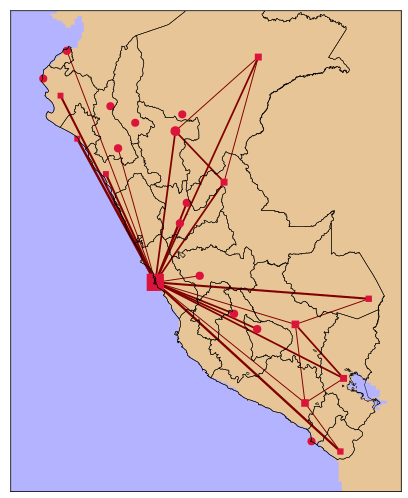

In [46]:
## Drawing the entire graph
plt.switch_backend("cairo")

## Creating the map object
fig = plt.figure(figsize=(7,10))
ax1 = fig.add_subplot(111)

map = Basemap(projection='merc', 
                llcrnrlon=-85.41, 
                llcrnrlat=-25.35, 
                urcrnrlon=-60.67, 
                urcrnrlat=-0.03,
                lon_0=-75.033593,
                lat_0=-9.1638517
                )
map.readshapefile('DEPARTAMENTOS/DEPARTAMENTOS', 'departments', drawbounds=True)
map.readshapefile('PERU/PERU', 'borders', drawbounds=True)
map.drawlsmask(land_color = "#e8c596", 
               ocean_color="#b3b3ff",
               resolution = 'l')

## Coordinates PM -- Converting it to x,y with Basemap
coord = peru_airports_g.new_vp("vector<double>")
longitude, latitude = peru_airports_g.vp.longitude, peru_airports_g.vp.latitude
for v in peru_airports_g.vertices():
        coord[v] = map(longitude[v], latitude[v])

## Drawing the graph
graph_draw(peru_airports_g, 
          pos=coord,
          vertex_size=prop_to_size(degree, 100000/3, 100000, power=3, log=True), 
          vertex_color="black", 
          vertex_fill_color="crimson",
          vertex_shape=international,
          nodesfirst=False,
          mplfig=ax1,
          edge_pen_width=prop_to_size(flight_number, 4e3, 10e3),
          edge_color="maroon"
          )

plt.savefig("all_airports.png", bbox_inches='tight')

from PIL import Image
img = Image.open("all_airports.png")
img = img.transpose(method=Image.FLIP_TOP_BOTTOM)
img.save("all_airports.png")

%matplotlib inline
from IPython import display
display.Image("./all_airports.png")

Following the principles of good visualization, each marker has been used to indicate a single characteristic: 
 - The position of the vertices is given by the coordinates of each airport. 
 - The shape of the vertix indicates whether it is an international airport or not. The squared vertices are international airports, the rounded vertices are only domestic. 
 - The size of the vertix indicates the degree. That is, the bigger the vertix, the more Peruvian domestic destinations you can fly to from that airport. 
 - The width of the edges indicate the number of total flights (back and forth) offered for that route. The thicker the edge, the easiest it is to find a flight between those two destinations. 

 Because of the flipped image bug, the title, the legend, and annotations had to be added over the saved png file. 

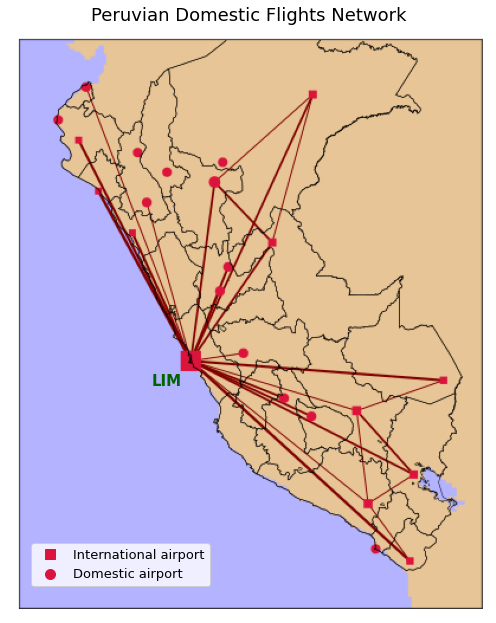

In [47]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='s', color='crimson', label='International airport', markerfacecolor='crimson', markersize=10, linestyle='None'),
                   Line2D([0], [0], marker='o', color='crimson', label='Domestic airport', markerfacecolor='crimson', markersize=10, linestyle='None')]

image = plt.imread("./all_airports.png")
fig, ax = plt.subplots(figsize=(7,10))
im = ax.imshow(image)

ax.axis("off")
plt.title("Peruvian Domestic Flights Network", fontdict={'color':  'black', 'weight': 'normal', 'size': 18})
plt.legend(handles=legend_elements, loc=(0.05, 0.05), prop={'size': 13})
plt.text(0.30, 0.39, "LIM", transform=ax.transAxes, fontdict={'color':  'darkgreen', 'weight': 'bold', 'size': 15})
plt.tight_layout()

plt.savefig("all_airports_complete.png")


### 2.2 Exploring Peru's Domestic Air Connectivity Further

The main insight from the previous visualization is that the airport in Lima is the most important one to keep Peruvian regions connected by air. To keep exploring this further, the next visualization removes that airport to see how the air connectivity between Peruvian regions would change if something were to happen to the airport in Lima. 

Initially, I tried removing the vertix for Lima, but it removed other points tied to it. Therefore, I tried another approach. I built a new network, without including the Lima vertix nor any edge related to it. This worked well and was helpful to gain more insights related to the research question. 




In [48]:
## To build the new network, the same code was used. The only modification was the removal of Lima from the dataset.
functioning_IATA = peru_airports_df["IATA"].to_list()
functioning_IATA.remove('LIM')

peru_routes_df = routes_df[routes_df['Source airport'].isin(functioning_IATA) & routes_df['Destination airport'].isin(functioning_IATA)]
peru_routes_df

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID
65,2I,8359,CUZ,2812,PEM,2808
67,2I,8359,IQT,2801,PCL,2781
68,2I,8359,IQT,2801,TPP,2806
74,2I,8359,PCL,2781,IQT,2801
76,2I,8359,PCL,2781,TPP,2806
77,2I,8359,PEM,2808,CUZ,2812
78,2I,8359,TPP,2806,IQT,2801
80,2I,8359,TPP,2806,PCL,2781
5655,AA,24,JUL,2792,AQP,2802
10852,AM,321,AQP,2802,JUL,2792


In [49]:
## After removing Lima, the vertices and edges need to be recalculated
## Matching each airport to an integer 
vertices_dict = {name: i for i, name in enumerate(functioning_IATA)}
vertices_dict

## Creating the edges
routes_edges = list(peru_routes_df[['Source airport', 'Destination airport']].itertuples(index=False, name=None))
routes_edges

## This will be relevant later, when creating the "flight number" edge property map
## Counts the total number of flights (back and forth) between each airport 
number_flights = dict(Counter([(vertices_dict[i], vertices_dict[j]) for i, j in routes_edges]))
number_flights

total_flights = dict({})

for x, y in number_flights:
    if (y, x) not in total_flights.keys():
        total_flights[(x, y)] = number_flights[(x, y)] + number_flights[(y, x)]

edges = list(total_flights.keys())
edges

[(18, 15), (10, 0), (10, 13), (0, 13), (5, 11), (5, 18), (11, 18), (11, 14)]

In [50]:
## Creating the vertices and edges for the new network without Lima
peru_airports_g = Graph(directed=False)
v = peru_airports_g.add_vertex(22)
e = peru_airports_g.add_edge_list(edges)

In [51]:
## All the following code is the same as the code for the initial visualization
## Degree PM
degree = peru_airports_g.degree_property_map(deg="total")
degree.a += 1

## IATA PM
iata = peru_airports_g.new_vp("string")
peru_airports_g.vp.iata = iata
for i, v in enumerate(peru_airports_g.vertices()):
        iata[v] = functioning_IATA[i]

## International PM 
international_airports = ["AQP", "LIM", "CIX", "CUZ", "TRU", "JUL", "IQT", "PCL", "TCQ", "PEM", "PIU"]
international = peru_airports_g.new_vp("int")
peru_airports_g.vp.international = international

for v in peru_airports_g.vertices():
        if iata[v] in international_airports:
                international[v] = 2
        else:
                international[v] = 0

## Number of flights PM
flight_number = peru_airports_g.new_ep("int")
peru_airports_g.ep.flight_number = flight_number

val = list(total_flights.values())

for i, e in enumerate(peru_airports_g.edges()):
        flight_number[e] = val[i]


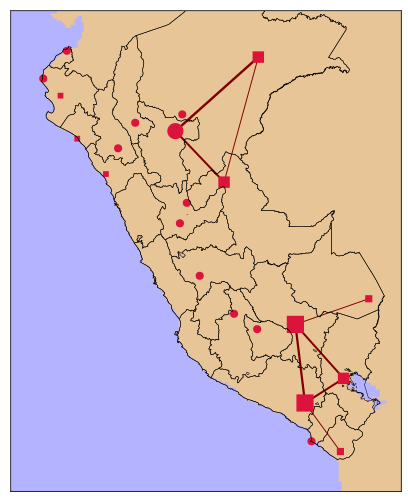

In [52]:
## Drawing the entire graph
## The code is the same than the code for the initial visualization. 
plt.switch_backend("cairo")

## Creating the map object
fig = plt.figure(figsize=(7,10))
ax1 = fig.add_subplot(111)

map = Basemap(projection='merc', 
                llcrnrlon=-85.41, 
                llcrnrlat=-25.35, 
                urcrnrlon=-60.67, 
                urcrnrlat=-0.03,
                lon_0=-75.033593,
                lat_0=-9.1638517
                )
map.readshapefile('DEPARTAMENTOS/DEPARTAMENTOS', 'departments', drawbounds=True)
map.readshapefile('PERU/PERU', 'borders', drawbounds=True)
map.drawlsmask(land_color = "#e8c596", 
               ocean_color="#b3b3ff",
               resolution = 'l')

## Coordinates PM -- Converting it to x,y with Basemap
peru_airports_df = peru_airports_df.drop(4)

# Longitude
longitude_list = peru_airports_df['Longitude'].tolist()
longitude = peru_airports_g.new_vp("float")
peru_airports_g.vp.longitude = longitude

for i, v in enumerate(peru_airports_g.vertices()):
        longitude[v] = longitude_list[i]

# Latitude
latitude_list = peru_airports_df['Latitude'].tolist()
latitude = peru_airports_g.new_vp("float")
peru_airports_g.vp.latitude = latitude

for i, v in enumerate(peru_airports_g.vertices()):
        latitude[v] = latitude_list[i]

# Coordinates       
coord = peru_airports_g.new_vp("vector<double>")
longitude, latitude = peru_airports_g.vp.longitude, peru_airports_g.vp.latitude
for v in peru_airports_g.vertices():
        coord[v] = map(longitude[v], latitude[v])

## Drawing the graph
graph_draw(peru_airports_g, 
          pos=coord,
          vertex_size=prop_to_size(degree, 100000/3, 100000, power=3, log=True), 
          vertex_color="black", 
          vertex_fill_color="crimson",
          vertex_shape=international,
          nodesfirst=False,
          mplfig=ax1,
          edge_pen_width=prop_to_size(flight_number, 4e3, 10e3),
          edge_color="maroon"
          )

plt.savefig("no_Lima.png", bbox_inches='tight')

from PIL import Image
img = Image.open("no_Lima.png")
img = img.transpose(method=Image.FLIP_TOP_BOTTOM)
img.save("no_Lima.png")

%matplotlib inline
from IPython import display
display.Image("./no_Lima.png")

The markers in this second visualization indicate the same things as in the first. Nevertheless, here they are listed again:
 - The position of the vertices is given by the coordinates of each airport. 
 - The shape of the vertix indicates whether it is an international airport or not. The squared vertices are international airports, the rounded vertices are only domestic. 
 - The size of the vertix indicates the degree. That is, the bigger the vertix, the more Peruvian domestic destinations you can fly to from that airport. 
 - The width of the edges indicate the number of total flights (back and forth) offered for that route. The thicker the edge, the easiest it is to find a flight between those two destinations. 

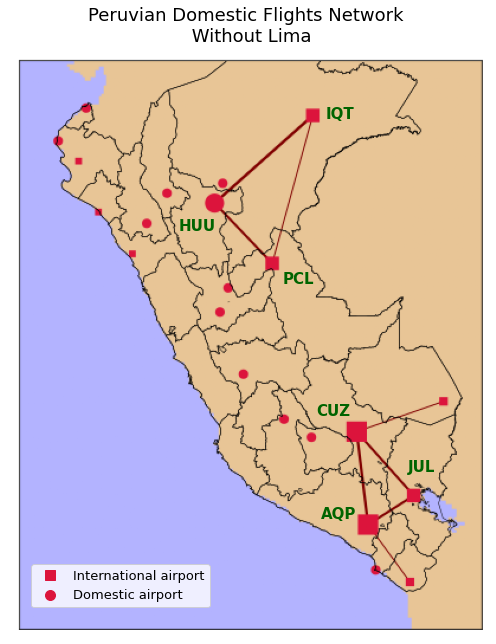

In [53]:
## Here too, the legend, title, and annotations had to me added manually because of the bug. 
legend_elements = [Line2D([0], [0], marker='s', color='crimson', label='International airport', markerfacecolor='crimson', markersize=10, linestyle='None'),
                   Line2D([0], [0], marker='o', color='crimson', label='Domestic airport', markerfacecolor='crimson', markersize=10, linestyle='None')]

image = plt.imread("./no_Lima.png")
fig, ax = plt.subplots(figsize=(7,10))
im = ax.imshow(image)

ax.axis("off")
plt.title("Peruvian Domestic Flights Network \n Without Lima", fontdict={'color':  'black', 'weight': 'normal', 'size': 18})
plt.legend(handles=legend_elements, loc=(0.05, 0.05), prop={'size': 13})
plt.text(0.64, 0.375, "CUZ", transform=ax.transAxes, fontdict={'color': 'darkgreen', 'weight': 'bold', 'size': 15})
plt.text(0.65, 0.20, "AQP", transform=ax.transAxes, fontdict={'color': 'darkgreen', 'weight': 'bold', 'size': 15})
plt.text(0.83, 0.28, "JUL", transform=ax.transAxes, fontdict={'color': 'darkgreen', 'weight': 'bold', 'size': 15})
plt.text(0.66, 0.88, "IQT", transform=ax.transAxes, fontdict={'color': 'darkgreen', 'weight': 'bold', 'size': 15})
plt.text(0.57, 0.60, "PCL", transform=ax.transAxes, fontdict={'color': 'darkgreen', 'weight': 'bold', 'size': 15})
plt.text(0.355, 0.69, "HUU", transform=ax.transAxes, fontdict={'color': 'darkgreen', 'weight': 'bold', 'size': 15})
plt.tight_layout()

plt.savefig("no_Lima_complete.png")

## 3. Final Visualization and Conclusions

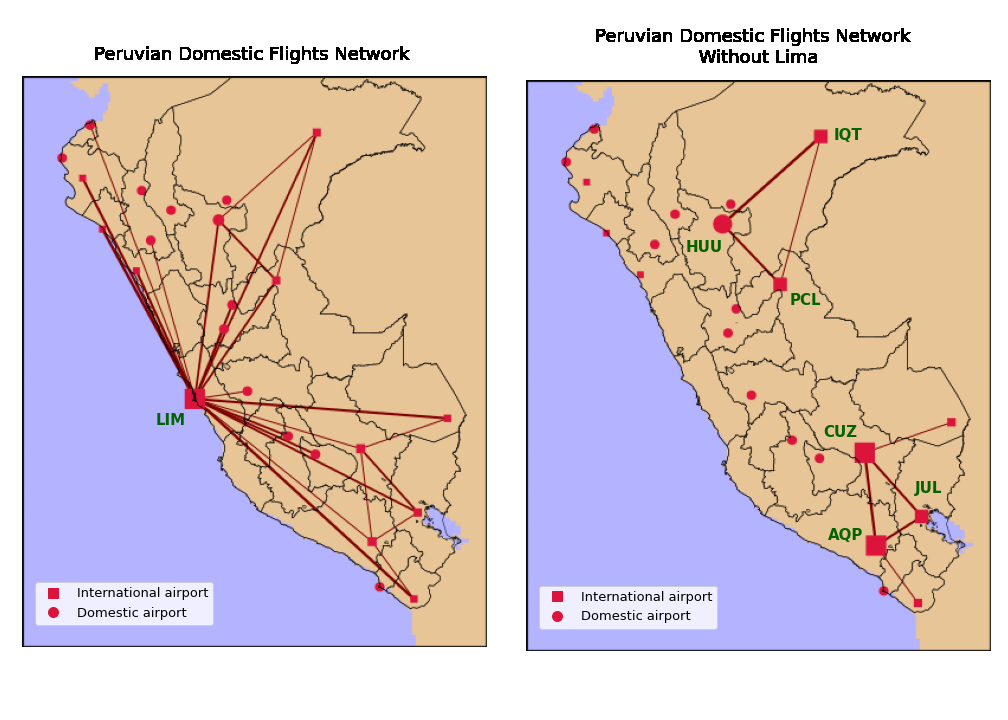

In [54]:
from PIL import Image

im1 = Image.open("./all_airports_complete.png")
im2 = Image.open("./no_Lima_complete.png")
def get_concat_h(im1, im2, color=(255, 255, 255)):
    dst = Image.new('RGB', (im1.width + im2.width, max(im1.height, im2.height)), color)
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst
get_concat_h(im1, im2).save('./joint.png')

%matplotlib inline
from IPython import display
display.Image("./joint.png")

To make the networks easier to compare and the change easier to percieve, both "before" and "after" are plotted next to each other. 

This initial plot provides interesting insights about the air connectivity among Peruvian regions: 
 - The biggest squared vertix is the airport in Lima, the capital city. By its degree and the thickness of most of the edges connecting it to other vertices, it is clear that Lima hosts the main airport in Peru. Moreover, several airports have only one edge, which keeps the region connected only to Lima by air transport. This further confirms that Lima is a highly centralized country, with significant differences between the capital and the other regions. 
 - If one wants to travel from one region to another, most of the times, a stop in Lima would be needed. 
 - Although most of the regions have at least one airport, the distribution is uneven. There are some regions that have no airports, while there are some with two. 
 - Some airports are inactive. This could be because the list of commercial airports in Wikipedia has information from 2022, but the Open Flights "routes" dataset was last updated in 2014. 
 - Peru has more domestic airports than international ones.

After removing the airport in Lima, the change in the air connectivity among Peruvian region is dramatic. Some conclusions can be drawn: 
 - As expected, most of the regions become unreachable by air if the Lima airport is removed. It is surprising that even some international airports remained connected to other regions within the country only through the airport in Lima. 
 - Another indicator of the disproportionate importance of Lima is the change in the degree and flight number in airports like IQT, HUU, PCL, and JUL. It is even more surprising in the case of CUZ, and AQP. The size of the vertices and the thickness of the edges are useful for picking this up. 
 - Two clusters of connected regions remain after removing Lima: 
   - The North-East region: These three airports (IQT, PLC, and HUU) are located in Peru's Amazon regions. Despite IQT and PCL being international airports, it looks like the HUU domestic airport is the busiest, being more flights both from HUU-IQT and HUU-PCL than from IQT-PCL directly. 
   - The Southern region: In contrast with the previous cluster, this one includes five international airports. Nevertheless, it is clear that CUZ, AQP, and JUL are the busiest and most important ones, as they keep the cluster together. It is not surprising that these regions remain connected without the airport in Lima, as they are highly touristic areas: Macchu Picchu is in Cuzco, the Misti Volcanoe is in Arequipa, and the Titicaca Lake is in Puno, region where Juliaca (JUL) is. 
 - Another surprising insight is that the North is significantly worse connected by air than other parts of the country, despite having several international airports. It is possible that it is because most of the northern cities might be easier to access by car that it would be to drive to the Amazon or to the Andes. 

As the final remark, this network analysis shows that air connectivity between Peruvian regions is highly dependent on the functioning of the airport in Lima. This makes sense, given the centralization of the country. Nevertheless, it also highlights that in a potential destruction or inhabilitation of the Lima airport, most of the commercial air traffic in Peru would be paralyzed. Therefore, it would be advisable to reduce the dependency to the airport in Lima and try to establish more direct routes between regions.


## 5. Bibliography

Geo GPS Perú. _Límite Borde Perú_. https://www.geogpsperu.com/2020/07/limite-peru-perimetro-borde-poligono.html


Geo GPS Perú. _Límite Departamental_. https://www.geogpsperu.com/2018/02/limite-departamental-politico-shapefile.html


OpenFlights. _Airport database_. January 2017. Distributed by OpenFligts.org. https://openflights.org/data.html


OpenFlights. _Route database_. June 2014. Distributed by OpenFlights.org. https://openflights.org/data.html


Wikipedia. _List of Airports in Peru_. March 4th, 2022. https://en.wikipedia.org/wiki/List_of_airports_in_Peru#:~:text=Of%20a%20total%20of%20234,which%2027%20feature%20scheduled%20services